# Figure A: Map

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import matplotlib
from matplotlib.colors import ListedColormap
import xarray as xr 
import glob
import os

#plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams.update({'font.size': 12})

import warnings
warnings.filterwarnings("ignore")

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
def compute_air_density(temperature, pressure):
    R_d = 287.05  # J/(kg·K), specific gas constant for dry air
    air_density = pressure / (R_d * temperature)
    return air_density

## Prepare Data

In [3]:
frp =  xr.open_mfdataset("/work/bb1174/user/jason/hamlite/icon_input/data_aus_2019/frp/emiss_GFAS_frp_wildfire_2019_aus_R02B10_DOM01.nc", engine = 'netcdf4').isel(time = 30)

h_path = os.path.join("/work/bb1262/b381531/frp_experiments/lam_aus_2019/run_20191226T000000-20191226T235955/", "lam_aus_2019_atm_vgrid_ml.nc")
h = xr.open_dataset(h_path, engine='netcdf4').zg.mean("ncells")
h = h.rename({"height_2": "height"})


lon = np.rad2deg(frp.clon)
lat = np.rad2deg(frp.clat)

In [4]:
dates = ["20191227","20191228", "20191229", "20191230"]
suffix = "000000Z.nc" #Adjust to read in a different time of the day

### Get data with fire heat

In [5]:
base_path = "/work/bb1262/b381531/frp_experiments/lam_aus_2019/"
pattern = "hamlite_trc_3d_ml_2019*"

file_list = []
for date in dates:
    run_dir = os.path.join(base_path, f"run_{date}T000000-{date}T235955/")
    files = glob.glob(os.path.join(run_dir, f"*{pattern}{suffix}"))
    file_list.extend(files)

In [6]:
# Sanity check
print("Found files:", len(file_list))

# Open datasets
ds_all = xr.open_mfdataset(file_list, engine='netcdf4', combine='by_coords')

# Access variables
ca_fire = ds_all.num_qca
dust_fire = ds_all.num_qdu
t = ds_all.ta
p = ds_all.pfull

Found files: 4


### Get data without fire heat

In [7]:
base_path = "/home/m/m300279/PROG/hamlite_cycl4/icon-mpim/experiments/lam_aus_2019b/"
pattern = "hamlite_trc_3d_ml_2019*"

file_list = []
for date in dates:
    run_dir = os.path.join(base_path, f"run_{date}T000000-{date}T235950/")
    files = glob.glob(os.path.join(run_dir, f"*{pattern}{suffix}"))
    file_list.extend(files)

In [8]:
# Sanity check
print("Found files:", len(file_list))

# Open datasets
ds_all = xr.open_mfdataset(file_list, engine='netcdf4', combine='by_coords')

# Access variables
ca_nofire = ds_all.num_qca
dust_nofire = ds_all.num_qdu

Found files: 4


In [9]:
lon = np.rad2deg(dust_fire.clon)
lat = np.rad2deg(dust_fire.clat)

## Calculate Burden

In [10]:
# For Carbonaceous aerosol
r_ca = 0.16e-6
rho_ca = 1987
volume_ca = (4/3) * np.pi * (r_ca ** 3)  # m³
particle_mass_ca = volume_ca * rho_ca 

# For Dust aerosol
r_du = 0.93e-6
rho_du = 2650
volume_du = (4/3) * np.pi * (r_du ** 3)  # m³
particle_mass_du = volume_du * rho_du 

In [11]:
rho = compute_air_density(t, p)
dz = -h.differentiate("height")

In [12]:
concentration_fire_ca = ca_fire * rho * particle_mass_ca * dz
concentration_nofire_ca = ca_nofire * rho * particle_mass_ca * dz

concentration_fire_du = dust_fire * rho * particle_mass_du * dz
concentration_nofire_du = dust_nofire * rho * particle_mass_du * dz

In [13]:
burden_fire_ca = concentration_fire_ca.sum("height") * 1000
burden_nofire_ca = concentration_nofire_ca.sum("height") * 1000

burden_fire_du = concentration_fire_du.sum("height") * 1000 #* 1000
burden_nofire_du = concentration_nofire_du.sum("height") * 1000 #* 1000


# Setting the value of a single pixel on the edge of the plot to a high value to avoid a buggy interaction between tricontourf and cartopy
# Cell 0 is located on the very upper edge of the plot. The pertubation is not visible in the plot
# I know this is not a very pretty way to do it but I don't know how else to solve this
burden_fire_ca[:,0] = 100000
burden_nofire_ca[:,0] = 100000
burden_fire_du[:,0] = 100000
burden_nofire_du[:,0] = 100000

## Plot Panels

In [14]:
# Get the colormaps right
nlevel = 50

base_cmap = plt.cm.get_cmap("gist_heat_r", nlevel)  
colors = base_cmap(np.linspace(0, 1, nlevel))
colors[0] = [1, 1, 1, 0]
#colors[1] = [1, 1, 1, 0.5]
#colors[2] = [1, 1, 1, 0.25]
custom_cmap_du = ListedColormap(colors)

base_cmap = plt.cm.get_cmap("Greys", nlevel)  
colors = base_cmap(np.linspace(0, 1, nlevel))
colors[0] = [1, 1, 1, 0]
colors[1] = [1, 1, 1, 0.25]
colors[2] = [1, 1, 1, 0.5]
colors[3] = [1, 1, 1, 0.75]
custom_cmap_ca = ListedColormap(colors)

In [18]:
# Some Settings for the plot
times = [0, 1, 2,3]

maxval_ca = 1
maxval_du = 1

levs_ca = np.arange(0, maxval_ca, maxval_ca / nlevel)
levs_du = np.arange(0, maxval_du, maxval_du / nlevel)

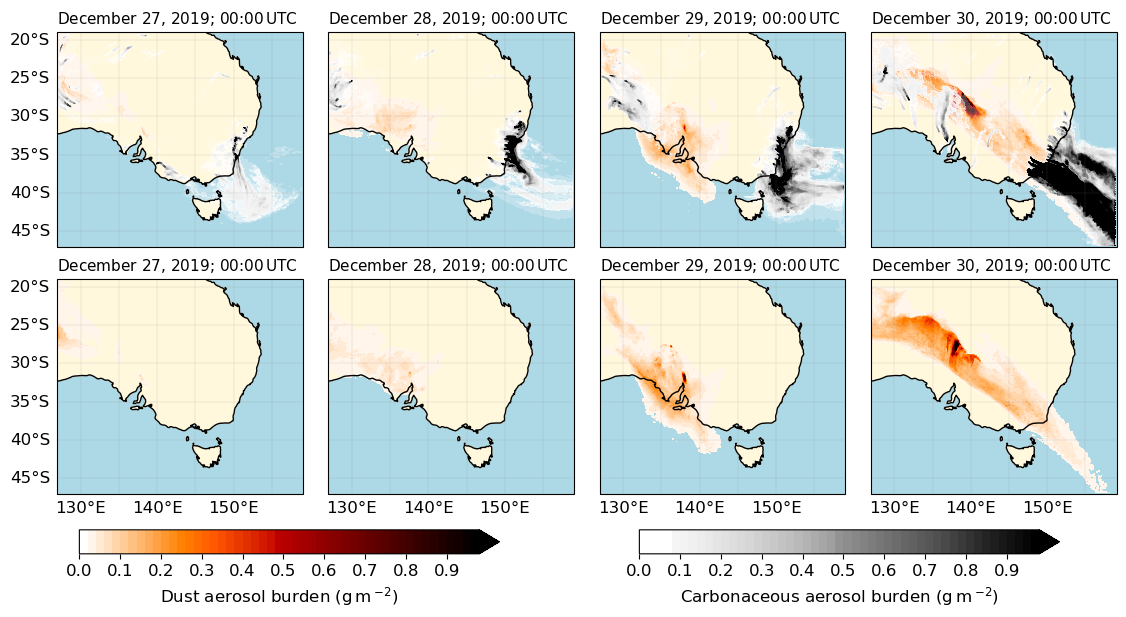

In [19]:
fig, axes = plt.subplots(
    nrows=2, ncols=len(times),
    subplot_kw={'projection': ccrs.PlateCarree()},
    figsize=(14, 6)
)

utc_string = f"; 00:00$\,$UTC"
titles_top = ["December 27, 2019"+utc_string ,"December 28, 2019"+utc_string,"December 29, 2019" + utc_string, "December 30, 2019" + utc_string]
titles_bottom = ["December 27, 2019" + utc_string, "December 28, 2019" + utc_string, "December 29, 2019" + utc_string, "December 30, 2019" + utc_string]

for i, t in enumerate(times):
    # Top row
    ax_top = axes[0, i]
    data_fire_du = burden_fire_du.isel(time=t)
    data_fire_ca = burden_fire_ca.isel(time=t)
    
    c1 = ax_top.tricontourf(lon, lat, data_fire_du, transform=ccrs.PlateCarree(),
                           cmap=custom_cmap_du, levels=levs_du, extend="max")
    c2 = ax_top.tricontourf(lon, lat, data_fire_ca, transform=ccrs.PlateCarree(),
                          cmap=custom_cmap_ca, levels=levs_ca, extend="max")
    
    ax_top.add_feature(cfeature.COASTLINE, linewidth=1)
    ax_top.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax_top.add_feature(cfeature.LAND, facecolor='cornsilk')
    ax_top.set_title(titles_top[i], loc="left", fontsize=11)

    # Gridlines and labels
    gl = ax_top.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    if i != 0:
        gl.left_labels = False
    gl.bottom_labels = False

    # Bottom row
    ax_bot = axes[1, i]
    data_nofire_du = burden_nofire_du.isel(time=t)
    data_nofire_ca = burden_nofire_ca.isel(time=t)
    
    ax_bot.tricontourf(lon, lat, data_nofire_du, transform=ccrs.PlateCarree(),
                       cmap=custom_cmap_du, levels=levs_du, extend="max")
    ax_bot.tricontourf(lon, lat, data_nofire_ca, transform=ccrs.PlateCarree(),
                       cmap=custom_cmap_ca, levels=levs_ca, extend="max")
    
    ax_bot.add_feature(cfeature.COASTLINE, linewidth=1)
    ax_bot.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax_bot.add_feature(cfeature.LAND, facecolor='cornsilk')
    ax_bot.set_title(titles_bottom[i], loc="left", fontsize=11)

    # Gridlines and labels
    gl = ax_bot.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    if i != 0:
        gl.left_labels = False
    gl.bottom_labels = True

# Draw colorbars
cbar_ax1 = fig.add_axes([0.15, 0.01, 0.3, 0.04])  # [left, bottom, width, height]
cbar_ax2 = fig.add_axes([0.55, 0.01, 0.3, 0.04])

# Draw colorbars
fig.colorbar(c1, cax=cbar_ax1, orientation="horizontal").set_label("Dust aerosol burden (g$\,$m$\,^{{-2}}$)")
fig.colorbar(c2, cax=cbar_ax2, orientation="horizontal").set_label("Carbonaceous aerosol burden (g$\,$m$\,^{{-2}}$)")


plt.subplots_adjust(
    hspace=0.15,  
    wspace=0.0,  
    right=0.9     
)

# Additional plot for easier testing

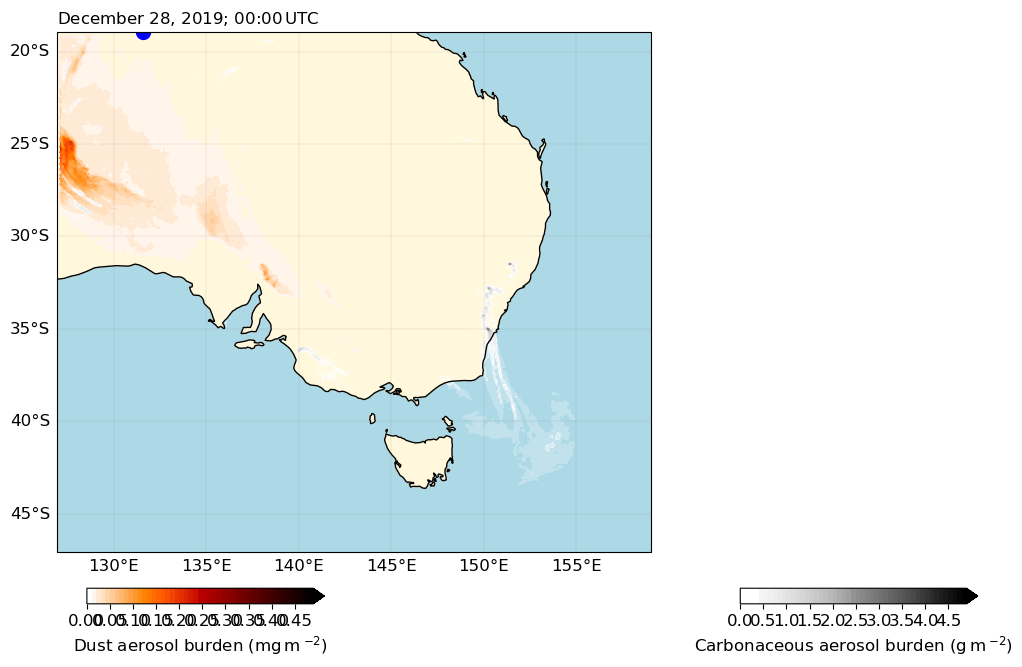

In [20]:
# Some Settings for the plot

t = 0  # or whichever index you want
maxval_ca = 5
maxval_du = 5e-1

levs_ca = np.arange(0, maxval_ca, maxval_ca / nlevel)
levs_du = np.arange(0, maxval_du, maxval_du / nlevel)


# Choose the timestep (e.g., t = 0)
utc_string = "; 00:00$\,$UTC"
title = "December 28, 2019" + utc_string  # Adjust based on t if needed

# Extract data
data_fire_du = burden_fire_du.isel(time=t)
data_fire_ca = burden_fire_ca.isel(time=t)

# Create single plot
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(9, 6))

# Plot data
c1 = ax.tricontourf(lon, lat, data_fire_du, transform=ccrs.PlateCarree(),
                    cmap=custom_cmap_du, levels=levs_du, extend="max")
c2 = ax.tricontourf(lon, lat, data_fire_ca, transform=ccrs.PlateCarree(),
                    cmap=custom_cmap_ca, levels=levs_ca, extend="max")

ax.scatter(lon[0], lat[0], color = "Blue", s = 100) # Check where the manipulated cell with the very high value is located to make sure it does not interfer with the plot

# Add features
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.LAND, facecolor='cornsilk')

# Title
ax.set_title(title, loc="left", fontsize=12)

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5)
gl.top_labels = False
gl.right_labels = False


cbar_ax1 = inset_axes(ax, width="40%", height="3%", loc='lower left',
                      bbox_to_anchor=(0.05, -0.1, 1, 1), bbox_transform=ax.transAxes, borderpad=0)

cbar_ax2 = inset_axes(ax, width="40%", height="3%", loc='lower right',
                      bbox_to_anchor=(0.55, -0.1, 1, 1), bbox_transform=ax.transAxes, borderpad=0)

fig.colorbar(c1, cax=cbar_ax1, orientation="horizontal").set_label("Dust aerosol burden (mg$\,$m$\,^{-2}$)")
fig.colorbar(c2, cax=cbar_ax2, orientation="horizontal").set_label("Carbonaceous aerosol burden (g$\,$m$\,^{-2}$)")

plt.tight_layout()
plt.show()